In [218]:
import pandas as pd
import numpy as np
import scipy.io
import scipy.linalg
import sklearn.metrics
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

def kernel(ker, X1, X2, gamma):
    K = None
    if not ker or ker == 'primal':
        K = X1
    elif ker == 'linear':
        if X2 is not None:
            K = sklearn.metrics.pairwise.linear_kernel(np.asarray(X1).T, np.asarray(X2).T)
        else:
            K = sklearn.metrics.pairwise.linear_kernel(np.asarray(X1).T)
    elif ker == 'rbf':
        if X2 is not None:
            K = sklearn.metrics.pairwise.rbf_kernel(np.asarray(X1).T, np.asarray(X2).T, gamma)
        else:
            K = sklearn.metrics.pairwise.rbf_kernel(np.asarray(X1).T, None, gamma)
    return K

class TCA:
    def __init__(self, kernel_type='primal', dim=30, lamb=1, gamma=1):
        '''
        Init func
        :param kernel_type: kernel, values: 'primal' | 'linear' | 'rbf'
        :param dim: dimension after transfer
        :param lamb: lambda value in equation
        :param gamma: kernel bandwidth for rbf kernel
        '''
        self.kernel_type = kernel_type
        self.dim = dim
        self.lamb = lamb
        self.gamma = gamma

    def fit(self, Xs, Xt):
        '''
        Transform Xs and Xt
        :param Xs: ns * n_feature, source feature
        :param Xt: nt * n_feature, target feature
        :return: Xs_new and Xt_new after TCA
        '''
        X = np.hstack((Xs.T, Xt.T))
        eps = np.finfo(float).eps
        a = np.linalg.norm(X, axis=0)
        a = np.maximum(a, eps)
        X /= a
        m, n = X.shape
        ns, nt = len(Xs), len(Xt)
        e = np.vstack((1 / ns * np.ones((ns, 1)), -1 / nt * np.ones((nt, 1))))
        M = e * e.T
        M = M / np.linalg.norm(M, 'fro')
        H = np.eye(n) - 1 / n * np.ones((n, n))
        K = kernel(self.kernel_type, X, None, gamma=self.gamma)
        n_eye = m if self.kernel_type == 'primal' else n
        a, b = np.linalg.multi_dot([K, M, K.T]) + self.lamb * np.eye(n_eye), np.linalg.multi_dot([K, H, K.T])
        w, V = scipy.linalg.eig(a, b)
        w = w.real
        V = V.real
        ind = np.argsort(w)
        A = V[:, ind[:self.dim]]
        Z = np.dot(A.T, K)
        b = np.linalg.norm(Z, axis=0)
        b = np.maximum(b, eps)
        Z /= b
        Xs_new, Xt_new = Z[:, :ns].T, Z[:, ns:].T
        return Xs_new, Xt_new

    def fit_predict(self, Xs, Ys, Xt, Yt):
        '''
        Transform Xs and Xt, then make predictions on target using 1NN
        :param Xs: ns * n_feature, source feature
        :param Ys: ns * 1, source label
        :param Xt: nt * n_feature, target feature
        :param Yt: nt * 1, target label
        :return: Accuracy and predicted_labels on the target domain
        '''
        Xs_new, Xt_new = self.fit(Xs, Xt)
        clf = KNeighborsClassifier(n_neighbors=1)
        clf.fit(Xs_new, Ys.ravel())
        y_pred = clf.predict(Xt_new)
        acc = sklearn.metrics.accuracy_score(Yt, y_pred)
        return acc, y_pred, Xs_new, Xt_new

class BDA:
    def __init__(self, kernel_type='primal', dim=30, lamb=1, mu=0.5, gamma=1, T=10, mode='BDA', estimate_mu=False):
        '''
        Init func
        :param kernel_type: kernel, values: 'primal' | 'linear' | 'rbf'
        :param dim: dimension after transfer
        :param lamb: lambda value in equation
        :param mu: mu. Default is -1, if not specificied, it calculates using A-distance
        :param gamma: kernel bandwidth for rbf kernel
        :param T: iteration number
        :param mode: 'BDA' | 'WBDA'
        :param estimate_mu: True | False, if you want to automatically estimate mu instead of manally set it
        '''
        self.kernel_type = kernel_type
        self.dim = dim
        self.lamb = lamb
        self.mu = mu
        self.gamma = gamma
        self.T = T
        self.mode = mode
        self.estimate_mu = estimate_mu

    def fit_predict(self, Xs, Ys, Xt, Yt):
        '''
        Transform and Predict using 1NN as JDA paper did
        :param Xs: ns * n_feature, source feature
        :param Ys: ns * 1, source label
        :param Xt: nt * n_feature, target feature
        :param Yt: nt * 1, target label
        :return: acc, y_pred, list_acc
        '''
        list_acc = []
        X = np.hstack((Xs.T, Xt.T))
        X /= np.linalg.norm(X, axis=0)
        m, n = X.shape
        ns, nt = len(Xs), len(Xt)
        e = np.vstack((1 / ns * np.ones((ns, 1)), -1 / nt * np.ones((nt, 1))))
        C = len(np.unique(Ys))
        H = np.eye(n) - 1 / n * np.ones((n, n))
        mu = self.mu
        M = 0
        Y_tar_pseudo = None
        Xs_new = None
        for t in range(self.T):
            N = 0
            M0 = e * e.T * C
            if Y_tar_pseudo is not None and len(Y_tar_pseudo) == nt:
                for c in range(0, C):
                    e = np.zeros((n, 1))
                    Ns = len(Ys[np.where(Ys == c)])
                    Nt = len(Y_tar_pseudo[np.where(Y_tar_pseudo == c)])

                    if self.mode == 'WBDA':
                        Ps = Ns / len(Ys)
                        Pt = Nt / len(Y_tar_pseudo)
                        alpha = Pt / Ps
                        mu = 1
                    else:
                        alpha = 1

                    tt = Ys == c
                    e[np.where(tt == True)] = 1 / Ns
                    yy = Y_tar_pseudo == c
                    ind = np.where(yy == True)
                    inds = [item + ns for item in ind]
                    e[tuple(inds)] = -alpha / Nt
                    e[np.isinf(e)] = 0
                    N = N + np.dot(e, e.T)

            # In BDA, mu can be set or automatically estimated using A-distance
            # In WBDA, we find that setting mu=1 is enough
            if self.estimate_mu and self.mode == 'BDA':
                if Xs_new is not None:
                    mu = estimate_mu(Xs_new, Ys, Xt_new, Y_tar_pseudo)
                else:
                    mu = 0
            M = (1 - mu) * M0 + mu * N
            M /= np.linalg.norm(M, 'fro')
            K = kernel(self.kernel_type, X, None, gamma=self.gamma)
            n_eye = m if self.kernel_type == 'primal' else n
            a, b = np.linalg.multi_dot(
                [K, M, K.T]) + self.lamb * np.eye(n_eye), np.linalg.multi_dot([K, H, K.T])
            w, V = scipy.linalg.eig(a, b)
            w = w.real
            V = V.real
            ind = np.argsort(w)
            A = V[:, ind[:self.dim]]
            Z = np.dot(A.T, K)
            Z /= np.linalg.norm(Z, axis=0)
            Xs_new, Xt_new = Z[:, :ns].T, Z[:, ns:].T

            clf = sklearn.neighbors.KNeighborsClassifier(n_neighbors=1)
            clf.fit(Xs_new, Ys.ravel())
            Y_tar_pseudo = clf.predict(Xt_new)
            acc = sklearn.metrics.accuracy_score(Yt, Y_tar_pseudo)
            list_acc.append(acc)
            print('{} iteration [{}/{}]: Acc: {:.4f}'.format(self.mode, t + 1, self.T, acc))
        return acc, Y_tar_pseudo, list_acc

dataset-archive: Child and Infant Mortality from Kaggle

In [96]:
filename = './dataset/archive/child-deaths-by-age.csv'
data = pd.read_csv(filename, dtype={'Deaths - All causes - Sex: Both - Age: 0-6 days (Number)':float,'Deaths - All causes - Sex: Both - Age: 7-27 days (Number)':float,'Deaths - All causes - Sex: Both - Age: 28-364 days (Number)':float,'Deaths - All causes - Sex: Both - Age: 1-4 years (Number)':float})

In [97]:
data_source = data[data['Year']==1990]
data_targrt = data[data['Year']==1995]
data_source

,Entity,Code,Year,Deaths - All causes - Sex: Both - Age: 7-27 days (Number),Deaths - All causes - Sex: Both - Age: 1-4 years (Number),Deaths - All causes - Sex: Both - Age: 0-6 days (Number),Deaths - All causes - Sex: Both - Age: 28-364 days (Number)
0,Afghanistan,AFG,1990,9869.0,21812.0,15560.0,30929.0
30,African Region (WHO),NaN,1990,291227.0,1578366.0,679377.0,1162478.0
60,Albania,ALB,1990,208.0,849.0,989.0,1524.0
90,Algeria,DZA,1990,6461.0,6742.0,13487.0,19201.0
120,American Samoa,ASM,1990,3.0,6.0,11.0,8.0
...,...,...,...,...,...,...,...
6690,World Bank Lower Middle Income,NaN,1990,798461.0,2235186.0,1894469.0,1873668.0
6720,World Bank Upper Middle Income,NaN,1990,230409.0,532908.0,600957.0,1056488.0
6750,Yemen,YEM,1990,8883.0,21986.0,19544.0,36883.0
6780,Zambia,ZMB,1990,4798.0,25781.0,7980.0,22240.0


In [288]:
Xs = data_source[['Deaths - All causes - Sex: Both - Age: 0-6 days (Number)','Deaths - All causes - Sex: Both - Age: 7-27 days (Number)','Deaths - All causes - Sex: Both - Age: 28-364 days (Number)','Deaths - All causes - Sex: Both - Age: 1-4 years (Number)']].reset_index(drop=True)
Ys = [data_source['Deaths - All causes - Sex: Both - Age: 1-4 years (Number)']<0.8*data_source['Deaths - All causes - Sex: Both - Age: 1-4 years (Number)'].mean(), data_source['Deaths - All causes - Sex: Both - Age: 28-364 days (Number)']<0.5*data_source['Deaths - All causes - Sex: Both - Age: 28-364 days (Number)'].mean()]
Ys[0] = Ys[0].map(lambda x: 1 if x else 0).reset_index(drop=True)
Ys[1] = Ys[1].map(lambda x: 1 if x else 0).reset_index(drop=True)
Ys = Ys[0] & Ys[1]
Xt = data_targrt[['Deaths - All causes - Sex: Both - Age: 0-6 days (Number)','Deaths - All causes - Sex: Both - Age: 7-27 days (Number)','Deaths - All causes - Sex: Both - Age: 28-364 days (Number)','Deaths - All causes - Sex: Both - Age: 1-4 years (Number)']].reset_index(drop=True)
Yt = [data_targrt['Deaths - All causes - Sex: Both - Age: 1-4 years (Number)']<0.8*data_targrt['Deaths - All causes - Sex: Both - Age: 1-4 years (Number)'].mean(), data_targrt['Deaths - All causes - Sex: Both - Age: 28-364 days (Number)']<0.8*data_targrt['Deaths - All causes - Sex: Both - Age: 28-364 days (Number)'].mean()]
Yt[0] = Yt[0].map(lambda x: 1 if x else 0).reset_index(drop=True)
Yt[1] = Yt[1].map(lambda x: 1 if x else 0).reset_index(drop=True)
Yt = Yt[0] & Yt[1]

In [289]:
tca = TCA(kernel_type='linear', dim=4, lamb=1, gamma=1)
acc, ypre, Xt_new, Xs_new = tca.fit_predict(Xs, Ys, Xt, Yt)
print(f'The accuracy of TCA is: {acc:.4f}')
print(ypre)
print(list(Yt))

The accuracy of TCA is: 0.8202
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 0 1 0 0 0 0 1 1 0 1 1 1 1
 1 1 1 1 1 1 0 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 0 1 1 1 1 0 1 1
 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 0 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 0 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 1 1]
[1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 

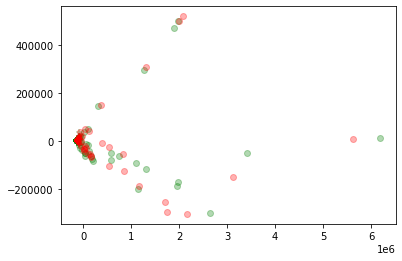

The accuracy of TCA is: 0.9693
[1 0 1 1 1 1 0 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1 1 1
 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 0 0 1 0 1 1 1 1 1 1 0 0 0 1 1 1 0 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 0 1
 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1
 0 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0
 0 0 0 1 1 1]
[1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 

In [290]:
pca = PCA(n_components=2)
Xt_pca = pca.fit_transform(Xt)
Xs_pca = pca.fit_transform(Xs)
plt.scatter(Xs_pca[np.where(Ys==1)][:,0], Xs_pca[np.where(Ys==1)][:,1], marker='+', c='g', alpha=0.3)
plt.scatter(Xs_pca[np.where(Ys==0)][:,0], Xs_pca[np.where(Ys==0)][:,1], marker='o', c='g', alpha=0.3)
plt.scatter(Xt_pca[np.where(Yt==1)][:,0], Xt_pca[np.where(Yt==1)][:,1], marker='+', c='r', alpha=0.3)
plt.scatter(Xt_pca[np.where(Yt==0)][:,0], Xt_pca[np.where(Yt==0)][:,1], marker='o', c='r', alpha=0.3)
plt.show()

tca = TCA(kernel_type='linear', dim=4, lamb=1, gamma=1)
acc, ypre, Xt_new, Xs_new = tca.fit_predict(Xs_pca, Ys, Xt_pca, Yt)
print(f'The accuracy of TCA is: {acc:.4f}')
print(ypre)
print(list(Yt))

In [291]:
pca = PCA(n_components=2)
Xt_pca = pca.fit_transform(Xt)
Xs_pca = pca.fit_transform(Xs)
clf = KNeighborsClassifier(n_neighbors=1)
clf.fit(Xs_pca, Ys.ravel())
y_pre = clf.predict(Xt_pca)
acc = sklearn.metrics.accuracy_score(Yt, ypre)
print(acc)
print(y_pre)

0.9692982456140351
[1 0 1 1 1 1 0 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1 1 1
 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 0 0 1 1 1 1 1 1 1 1 0 0 0 1 1 1 0 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1
 1 1 0 1 1 0 1 1 1 1 1 1 0 1 1 1 1 1 0 0 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 0 1
 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1
 0 1 1 0 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 0 0 0
 0 0 0 1 1 1]


In [292]:
np.where((y_pre==ypre)==False)

(array([ 57, 113, 116, 129, 130, 137, 196, 207]),)

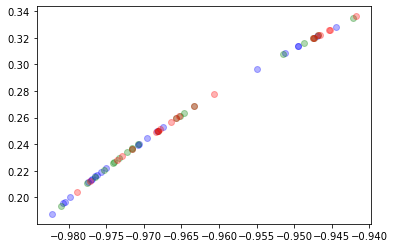

In [212]:
data1 = Xs_new[np.where(Yt==1)]
data2 = Xt_new[np.where(ypre==1)]
data3 = Xt_new[np.where(Yt==1)]
plt.scatter(data1[:,0], data1[:,1],c='b', alpha=0.3)
plt.scatter(data3[:,0], data3[:,1],c='g', alpha=0.3)
plt.scatter(data2[:,0], data2[:,1],c='r', alpha=0.3)
plt.show()

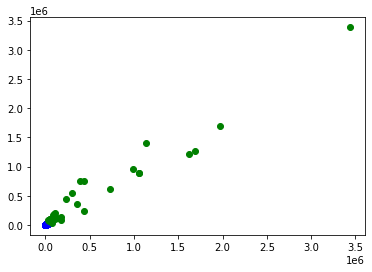

In [295]:
data1 = np.array(Xt)[np.where(Yt==1)]
data2 = np.array(Xt)[np.where(Yt==0)]
import matplotlib.pyplot as plt
plt.scatter(data1[:,3], data1[:,2],c='b')
plt.scatter(data2[:,3], data2[:,2],c='g')
plt.show()

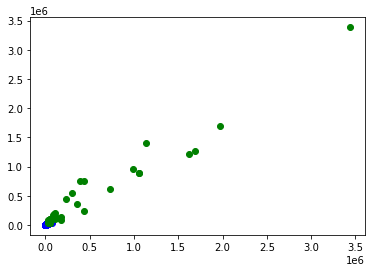

In [296]:
data1 = np.array(Xt)[np.where(ypre==1)]
data2 = np.array(Xt)[np.where(ypre==0)]
import matplotlib.pyplot as plt
plt.scatter(data1[:,3], data1[:,2],c='b')
plt.scatter(data2[:,3], data2[:,2],c='g')
plt.show()

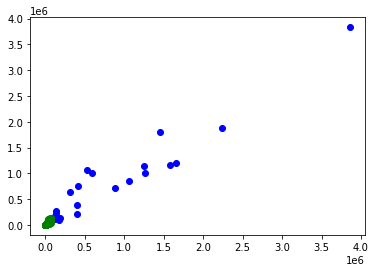

In [152]:
data1 = np.array(Xs)[np.where(Ys==1)]
data2 = np.array(Xs)[np.where(Ys==0)]
import matplotlib.pyplot as plt
plt.scatter(data1[:,3], data1[:,2],c='b')
plt.scatter(data2[:,3], data2[:,2],c='g')
plt.show()